# 台鐵車站的資料分析與視覺化 Part 1. 資料取得

一直很想做個data analysis相關的side project，無奈之前都不知道該做什麼。前陣子在政府公開資料庫中無意發現台鐵運量的資料集，覺得蠻有趣的(因為我超愛搭火車)，所以便著手開始這個計畫。

在政府的公開資料庫有提供每個車站的基本資料(中英文車站名稱及代碼、地址、經緯度、電話等)[1](https://data.gov.tw/dataset/33425)，以及每個車站日進出人數[2](https://data.gov.tw/dataset/8792)。但我還想要有更多的資料來協助分析，這時候我想到了維基百科。

稍微觀察一下維基百科的頁面，我認為右側的資訊盒(紅框處)的資訊較為一致，可以降低後續處理的門檻。雖然不知道用不用的到，但我想要爬的內容有：
* 車站等級
* 車站距離
* 車站的維基百科連結
* 車站啟用日期
* 車站位於哪條線上

> 維基百科其實有提供API，但我沒有研究怎麼用......。也許用了就不用這麼麻煩了。不過可以練爬蟲也是不錯啦！

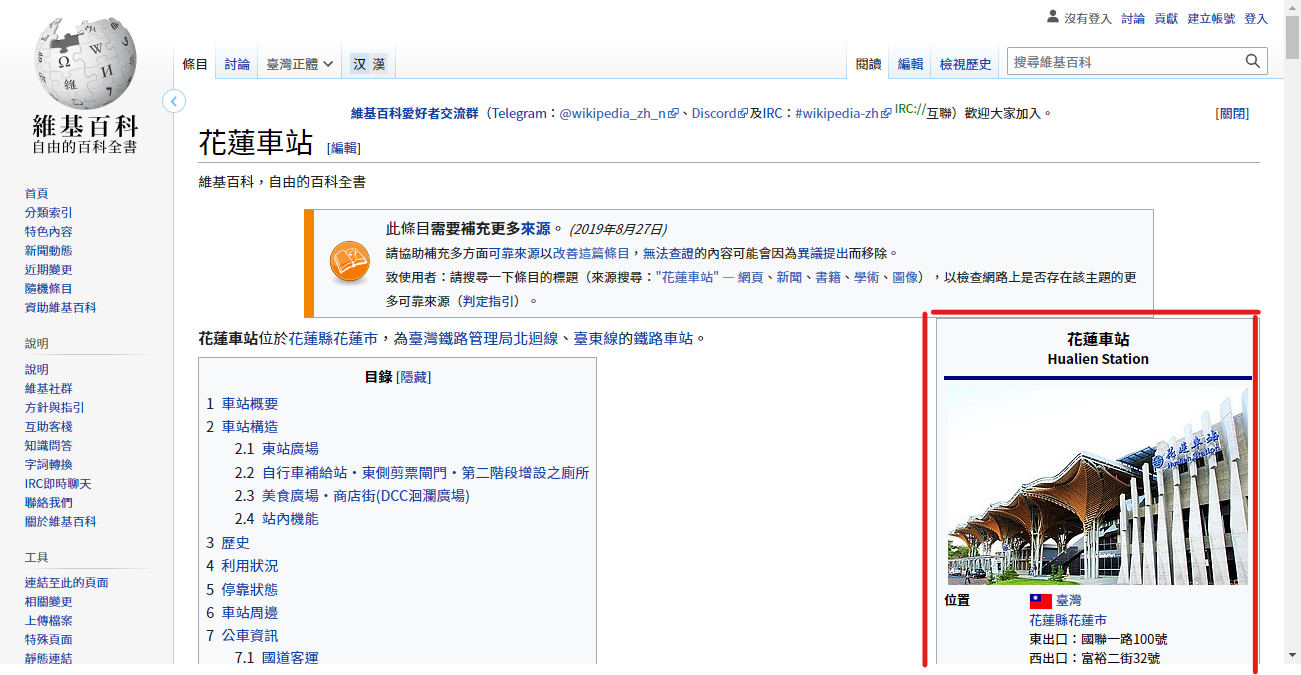

以下是資訊盒提供的相關資訊

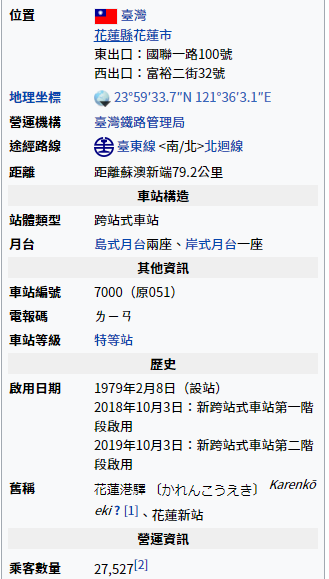

## 1. 載入必要套件

In [5]:
from bs4 import BeautifulSoup
import requests

但是不太可能自己搜尋一個一個車站的維基百科，我希望可以找到有個地方有所有車站的資訊，果然維基百科沒讓我失望，以下這個連結可以一次看到所有的車站：
https://zh.wikipedia.org/wiki/%E8%87%BA%E7%81%A3%E9%90%B5%E8%B7%AF%E8%BB%8A%E7%AB%99%E5%88%97%E8%A1%A8

但觀察他的欄位，雖然對一般人來說，這樣的表格很好閱讀，但對爬取資料來說，這有點麻煩，因為有太多的合併欄位了。我道行還不夠，不知道該怎麼處理這種情形，所以持續尋找還有沒有更適合爬取的表格。

以下圖為例，錫口與松山的前三個欄位是合併在一起的，且錫口的第五欄是空值，處理上比較麻煩。諸如此類的問題，讓我放棄爬取這個表格。
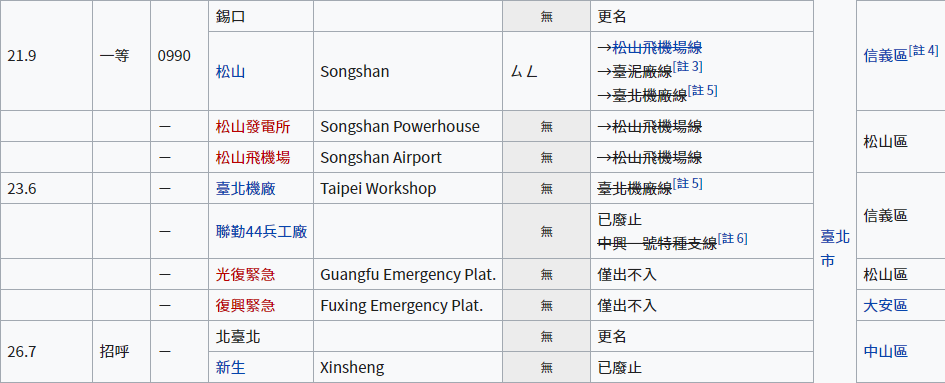

果然皇天不負苦心人XD，如果用各個路線區間的表格，那就會是很乾淨的表格！如下圖：
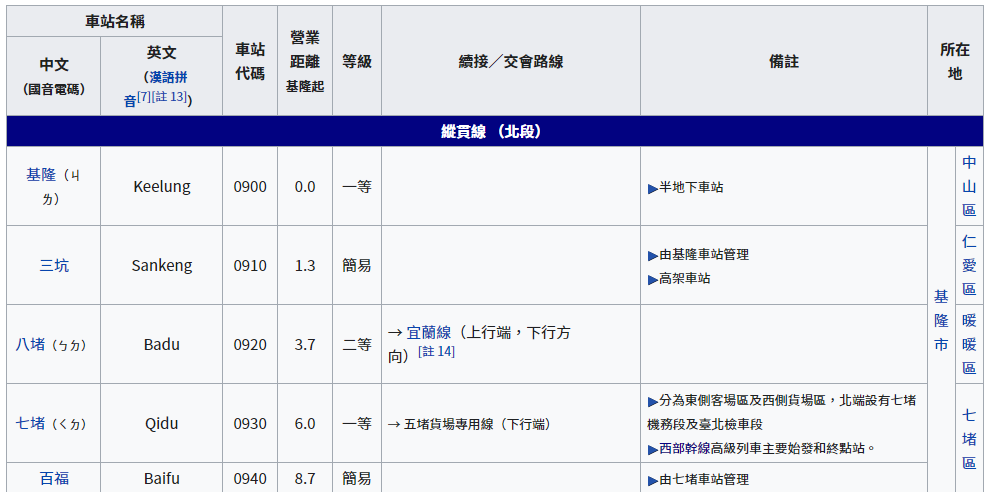
你可能會發現，最右側的所在地也是合併的表格，但因為我沒有要抓取到那邊的資料，所以對我不會有影響~
*beautifulsoup的抓取方式是認**第幾個**，所以有合併欄位或空值很容易數錯，但因為這個表格的合併欄位在最後面，所以不會數到那邊*

從上面的圖可以發現，我要的車站等級、距離、連結都有了！(連結就在中文車站名內，只要爬取這個超連結指向的位置就可以得到每個車站維基百科頁面的連結)

根據維基百科上的分類，路線可以分成：
1. 縱貫線（北段）
2. 海岸線（海線）
3. 臺中線（山線）
4. 成追線
5. 縱貫線（南段）
6. 屏東線
7. 南迴線
8. 宜蘭線
9. 北迴線
10. 臺東線
11. 深澳線
12. 平溪線
13. 內灣線
14. 六家線
15. 集集線
16. 沙崙線

其中成追線的路線與其他的重複，所以就去掉，總共要爬15條路線

## 2. 爬取路線資訊

> 當時是邊試邊做，所以程式碼有些凌亂，另外我認為應該建構一個更完整的函式來處理會遇到的各種情況，而不是遇到例外就新建一個函式。這些是未來的修正方向，但因為並非緊急事項，且不想佔用太多維基百科的網路資源，所以有空我再來修改。

### 縱貫線（北段）

以下是爬取網站所有內容的程式碼

In [6]:
BASE_URL = 'https://zh.wikipedia.org/wiki/%E7%B8%B1%E8%B2%AB%E7%B7%9A_(%E5%8C%97%E6%AE%B5)'
HEADERS = {'User-Agent': 'Mozilla/5.0'}

def get_Station_soup(link=BASE_URL):
    response = requests.get(url=link, headers=HEADERS)
    return BeautifulSoup(response.content, 'lxml')

In [70]:
soup = get_Station_soup()

接著進行parsing，擷取自己需要的部分，也就是頁面中的表格：

In [106]:
table_CentralNorth = soup.select_one('table.wikitable')

In [76]:
def get_column_titles(table):
    cols = []
    for th in table.select_one('tr').select('th'):
        cols.append(th.text)
    return cols

看看這個表頭，這就是我要的表格沒錯

In [107]:
get_column_titles(table_CentralNorth)

['車站名稱\n', '車站代碼\n', '營業里程基隆起\n', '等級\n', '續接／交會路線\n', '備註\n', '所在地\n']

接者抓取我要的欄位：距離、等級與網址。為了能跟之前的資料合併處理，因此我需要其他的欄位讓我可以辨識這是哪個車站，所以額外抓了車站名稱跟代碼。抓取到的資料用dict包裝，之後弄成.json檔輸出。

以下是寫成一個函式負責處理抓取欄位的部分：

In [103]:
def get_station(table):
    stations = []
    for row in table.select('tr')[3:]:
        stations.append({
            'Station': row.select('td')[0].text,
            'Code': row.select('td')[2].text,
            'Distance': row.select('td')[3].text,
            'Level': row.select('td')[4].text,
            'Link': row.find('a').attrs['href']
        })
    return stations

In [108]:
table_CentralNorth.select('tr')[3].find('a').attrs['href']

'/wiki/%E5%9F%BA%E9%9A%86%E8%BB%8A%E7%AB%99'

In [110]:
Central_North = get_station(table_CentralNorth)

### 海岸線（海線）

同樣的步驟繼續進行：

In [129]:
soup_Coast = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E6%B5%B7%E5%B2%B8%E7%B7%9A_(%E8%87%BA%E9%90%B5)')

In [130]:
table_Coast = soup_Coast.select_one('table.wikitable')

但我發現這張表的格式跟之前的不太一樣，因此重寫了一個函式 *(錯誤示範，應該包裝成一個更comprehensive的函式才對)*

In [138]:
def get_station_typeCoast(table):
    stations = []
    for row in table.select('tr')[2:]:
        stations.append({
            'Station': row.select('td')[0].text,
            'Code': row.select('td')[2].text,
            'Distance': row.select('td')[3].text,
            'Level': row.select('td')[4].text,
            'Link': row.find('a').attrs['href']
        })
    return stations

In [137]:
table_Coast.select('tr')[2].select('td')[0]

<td><a href="/wiki/%E7%AB%B9%E5%8D%97%E8%BB%8A%E7%AB%99" title="竹南車站">竹南</a><font size="-2"><span style="font-weight: 400">（ㄓㄋ）</span></font>
</td>

In [139]:
Coast = get_station_typeCoast(table_Coast)

之後就是一直持續這樣的流程，把所有路線爬完

### 臺中線（山線）

In [141]:
soup_TC = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E8%87%BA%E4%B8%AD%E7%B7%9A')

In [142]:
table_TC = soup_TC.select_one('table.wikitable')

In [145]:
Taichung = get_station_typeCoast(table_TC)

### 縱貫線（南段）

In [147]:
soup_CentralSouth = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E7%B8%B1%E8%B2%AB%E7%B7%9A_(%E5%8D%97%E6%AE%B5)')

In [151]:
table_CentralSouth = soup_CentralSouth.select('table.wikitable')[1]

In [152]:
Central_South = get_station_typeCoast(table_CentralSouth)

### 屏東線

In [154]:
soup_Pingtung = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%B1%8F%E6%9D%B1%E7%B7%9A')

In [155]:
table_Pingtung = soup_Pingtung.select_one('table.wikitable')

In [157]:
Pingtung = get_station_typeCoast(table_Pingtung)

### 南迴線

In [160]:
soup_South = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%8D%97%E8%BF%B4%E7%B7%9A')

In [161]:
table_South = soup_South.select_one('table.wikitable')

In [163]:
def get_station_typeSouth(table):
    stations = []
    for row in table.select('tr')[1:]:
        stations.append({
            'Station': row.select('td')[0].text,
            'Code': row.select('td')[2].text,
            'Distance': row.select('td')[3].text,
            'Level': row.select('td')[4].text,
            'Link': row.find('a').attrs['href']
        })
    return stations

In [164]:
South = get_station_typeSouth(table_South)

### 宜蘭線

In [166]:
soup_Yilan = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%AE%9C%E8%98%AD%E7%B7%9A')

In [167]:
table_Yilan = soup_Yilan.select_one('table.wikitable')

In [178]:
def get_station_typeYilan(table):
    stations = []
    for row in table.select('tr')[1:]:
        stations.append({
            'Station': row.select('td')[0].text,
            'Code': row.select('td')[3].text,
            'Distance': row.select('td')[4].text,
            'Level': row.select('td')[5].text,
            'Link': row.find('a').attrs['href']
        })
    return stations

In [179]:
Yilan = get_station_typeYilan(table_Yilan)

### 北迴線

In [181]:
soup_North = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%8C%97%E8%BF%B4%E7%B7%9A')

In [183]:
table_North = soup_North.select_one('table.wikitable')

In [185]:
North = get_station_typeYilan(table_North)

### 臺東線

In [187]:
soup_Taitung = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E8%87%BA%E6%9D%B1%E7%B7%9A')

In [188]:
table_Taitung = soup_Taitung.select_one('table.wikitable')

In [189]:
Taitung = get_station_typeSouth(table_Taitung)

### 平溪線

In [192]:
soup_Pingxi = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%B9%B3%E6%BA%AA%E7%B7%9A')

In [193]:
table_Pingxi = soup_Pingxi.select_one('table.wikitable')

In [194]:
Pingxi = get_station_typeSouth(table_Pingxi)

### 內灣線

In [196]:
soup_Neiwan = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%85%A7%E7%81%A3%E7%B7%9A')

In [197]:
table_Neiwan = soup_Neiwan.select_one('table.wikitable')

In [209]:
def get_station_typeNeiwan(table):
    stations = []
    for row in table.select('tr')[2:]:
        stations.append({
            'Station': row.select('td')[0].text,
            'Code': row.select('td')[2].text,
            'Distance': row.select('td')[3].text,
            'Level': row.select('td')[4].text,
            'Link': row.find('a').attrs['href']
        })
    return stations

In [210]:
Neiwan = get_station_typeNeiwan(table_Neiwan)

### 六家線

In [212]:
soup_Liujia = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E5%85%AD%E5%AE%B6%E7%B7%9A')

In [213]:
table_Liujia = soup_Liujia.select_one('table.wikitable')

In [214]:
Liujia = get_station_typeSouth(table_Liujia)

### 集集線

In [216]:
soup_Jiji = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E9%9B%86%E9%9B%86%E7%B7%9A')

In [217]:
table_Jiji = soup_Jiji.select_one('table.wikitable')

In [218]:
Jiji = get_station_typeSouth(table_Jiji)

### 沙崙線

In [220]:
soup_Shalun = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E6%B2%99%E5%B4%99%E7%B7%9A')

In [223]:
table_Shalun = soup_Shalun.select('table.wikitable')[1]

In [224]:
Shalun = get_station_typeSouth(table_Shalun)

### 深澳線

In [226]:
soup_NorthCoast = get_Station_soup(link='https://zh.wikipedia.org/wiki/%E6%B7%B1%E6%BE%B3%E7%B7%9A')

In [227]:
table_NorthCoast = soup_NorthCoast.select_one('table.wikitable')

深澳線的格式跟別人不一樣，因為他沒有附上車站等級。但因為他只有3個車站，所以我就人工幫他補上了。如果車站數量多的話，要另覓方法處理。

In [231]:
NorthCoast = []
for row, lv in zip(table_NorthCoast.select('tr')[1:], ['一等', '招呼', '招呼']):
    NorthCoast.append({
        'Station': row.select('td')[0].text,
        'Code': row.select('td')[2].text,
        'Distance': row.select('td')[3].text,
        'Level': lv,
        'Link': row.find('a').attrs['href']
    })

## 3. 爬蟲小總結

我不常做爬蟲(這應該算是第一次在沒有看教學的情況下自己爬)，所以剛開始覺得有點抖，不過實際爬過一次之後，其實就覺得還好。兩個小訣竅：
* 細心：要不斷確認自己爬的資料究竟是不是符合預期，因此要不斷dive in html code，來回檢查
* 觀察：知道網站的每個元素是怎麼被包裝的，從哪邊下手比較容易，每個元素之間有什麼共通點與相異點等等

我想，掌握這兩個心法，要入門爬蟲應該不會太難，剩下的就是技術跟經驗了！

## 4. 初步整理

這邊我只是把所有的路線資料整合在一起然後輸出成.json，剩下的我還是在pandas處理好了~

In [234]:
all_station = []
for i in [NorthCoast, Central_North, Coast, Taichung, Central_South, Pingtung,\
     South, Yilan, North, Taitung, Pingxi, Neiwan, Liujia,Jiji, Shalun]:
     all_station.extend(i)

In [2]:
import json

In [240]:
with open('stationinfo.json', 'w') as fout:
    json.dump(all_station , fout)

In [3]:
with open(r"stationinfo.json", "r") as read_file:
    data = json.load(read_file)

## 5. 爬取各個車站頁面

這邊的話要善用前面抓取到的維基百科各車站連結，這樣就不用自己一個車站一個車站搜尋了！可以全自動化~

但我們抓取到的連結不是完整的連結，先將他補成完整的連結：

In [77]:
link = []
for i in data:
    link.append('https://zh.wikipedia.org'+i['Link'])

先試著抓一個看看：

In [78]:
soup = get_Station_soup(link[0])

In [109]:
soup.find('th', string='启用日期').find_parent('tr').select_one('td').text

'1919年5月5日'

In [122]:
soup.find('th', string='途经线路').find_parent('tr').find('td').text

' 宜蘭線、深澳線'

在做這步之前，我有先看過數個車站的維基百科頁面，確認在資訊盒內都有啟用日期與途經線路兩項資訊，顯示名稱也都是如此(i.e. 所有車站的資訊盒，代表車站啟用日期的標籤都叫做"啟用日期"，代表他在哪個線路上的標籤都叫做"途經線路")，所以就放心的讓爬蟲自動化處理。另外可以看到，雖然我們在頁面上看到的是繁體中文，但如果抓取資訊盒內的所使用的表頭字串，會發現其實裡面是存簡體字喔！

實驗成功後，開始大規模自動化，然後存成.json檔：

我有瞄到抓取下來的有些連結不是導向到車站的維基百科頁面，這有可能導致程式報錯，所以特別加了例外處理讓他可以順順的跑完

In [128]:
vcard = []

for i in range(len(data)):
    soup = get_Station_soup(link[i])
    try:
        year = soup.find('th', string='启用日期').find_parent('tr').select_one('td').text
    except:
        year = 0
    try:
        line = soup.find('th', string='途经线路').find_parent('tr').find('td').text
    except:
        line = 0
    vcard.append({
        'Station':sta[i],
        'Open': year,
        'Line': line
    })

In [130]:
with open('stationwiki.json', 'w') as fout:
    json.dump(vcard , fout)

In [131]:
with open(r"stationwiki.json", "r") as read_file:
    data2 = json.load(read_file)